# Bay Wheels (Ford GoBike) Data Visualization

## by Bushra Alsunaidi


## Investigation Overview

This investigation aims to find out the features of the Bay Wheels dataset that would affect in increasing the bike trips (i.e., increase the business market) 

## Dataset Overview

This dataset contains information, gathered on July 2020, about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. It includes about 154,967 bike trips and 13 features such as the start/end date and time, the start/end station name, the user type, and the bike type. About 72k data records were removed due to quality issues, and these columns: trip duration, start day of the week, and the start hour were added to analyze the data accordingly.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# Load the dataset into panda dataframe
df = pd.read_csv('202007-baywheels-tripdata.csv')

In [3]:
# Create a copy of the dataset
dfc = df.copy()

In [4]:
# Fix the datatype
dfc.started_at = pd.to_datetime(dfc.started_at)
dfc.ended_at = pd.to_datetime(dfc.ended_at)
dfc.start_station_id = dfc.start_station_id.astype('str')
dfc.end_station_id = dfc.end_station_id.astype('str')
dfc.rideable_type = dfc.rideable_type.astype('category')
dfc.member_casual = dfc.member_casual.astype('category')

In [5]:
# Add a duration variable for a ride in sec
dfc['duration_sec'] = (dfc.ended_at - dfc.started_at).dt.seconds
dfc['started_day']= dfc.started_at.dt.strftime('%a')

In [6]:
# Fix the started_day to ordered category datatype
weekdays = ['Mon','Tue','Wed','Thu','Fri', 'Sat', 'Sun']
dfc.started_day = pd.Categorical(dfc.started_day, categories=weekdays, ordered=True)

In [7]:
# Delete the rows with null values
dfc = dfc[dfc.end_station_id.notnull()==True]
dfc = dfc[dfc.end_station_name.notnull()==True]
dfc = dfc[dfc.start_station_name.notnull()==True]

## Distribution of Trip Duration in Seconds

The distribution is positively skewed, which mean that most of the data falls to the right. The peak of the histogram, where most of the trips occurs, is held in the interval of 500-700 seconds, i.e., most of the trips took 8-13 minutes long.

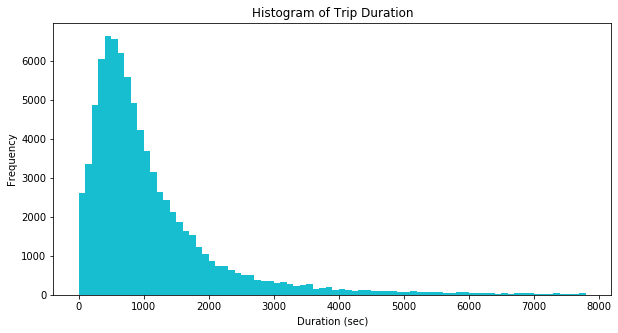

In [8]:
base_color = sb.color_palette()[9]
bins = np.arange(0, 7757+100, 100)
plt.figure(figsize=[10, 5])

plt.hist(data=dfc, x='duration_sec', bins=bins, color=base_color);
plt.title('Histogram of Trip Duration')
plt.xlabel('Duration (sec)');
plt.ylabel('Frequency');

In [9]:
# Filter out the outliers of trip records
dfc = dfc.query('duration_sec <= 7757')
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82695 entries, 1 to 154966
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ride_id             82695 non-null  object        
 1   rideable_type       82695 non-null  category      
 2   started_at          82695 non-null  datetime64[ns]
 3   ended_at            82695 non-null  datetime64[ns]
 4   start_station_name  82695 non-null  object        
 5   start_station_id    82695 non-null  object        
 6   end_station_name    82695 non-null  object        
 7   end_station_id      82695 non-null  object        
 8   start_lat           82695 non-null  float64       
 9   start_lng           82695 non-null  float64       
 10  end_lat             82695 non-null  float64       
 11  end_lng             82695 non-null  float64       
 12  member_casual       82695 non-null  category      
 13  duration_sec        82695 non-null  int64    

## User Type Distribution Among the Number of Weekly Bike Rentals

Members slightly more inclined to rent a bike on weekdays in July 2020 than casual users. However, on weekdays, casual users tend to ride the Bay Wheels bike more.

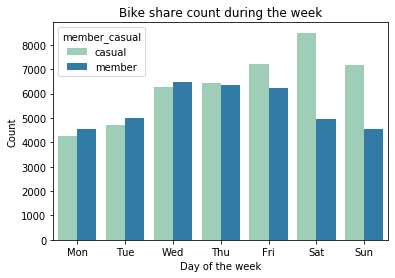

In [10]:
sb.countplot(data = dfc, x = 'started_day', hue = 'member_casual', palette="YlGnBu")
plt.title('Bike share count during the week')
plt.xlabel('Day of the week');
plt.ylabel('Count');

## Bike Type Distribution Among Users

After filtering the outliers of the duration column, it turns out that regardless of whether the rider is a member or a casual user, the docked bike was utilized more than the electric bike.

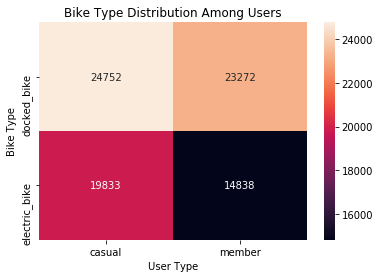

In [11]:
ct_counts = dfc.groupby(['rideable_type', 'member_casual']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'rideable_type', columns = 'member_casual', values = 'count')
sb.heatmap(ct_counts, annot = True, fmt = 'd' );
plt.title('Bike Type Distribution Among Users');
plt.xlabel('User Type');
plt.ylabel('Bike Type');

## The Weekly Average Ride Time for Users in Seconds.

The average trip duration of members is less than that for casual users on each day of the week. Nevertheless, the average is higher on the weekends for both users. This shows how it become demandable to rent a bike at the weekends, especially for casual riders.

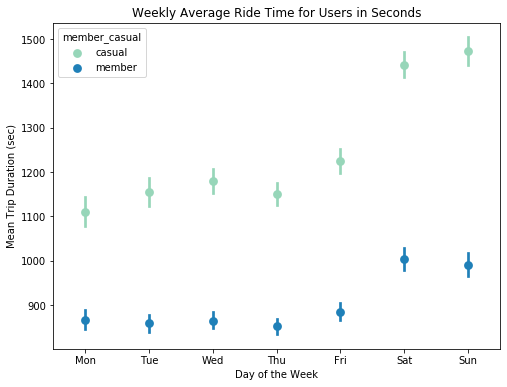

In [12]:
plt.figure(figsize = [8,6])
sb.pointplot(data=dfc, x='started_day', y='duration_sec', hue='member_casual', 
             palette='YlGnBu', linestyles = '');
plt.title('Weekly Average Ride Time for Users in Seconds')
plt.xlabel('Day of the Week');
plt.ylabel('Mean Trip Duration (sec)');
dfc['started_hour']= dfc.started_at.dt.hour

## The Hourly Usage Rate for Each Bike Type Per Week.

The demand for a docked bike is concentrated on the weekends, especially on Saturday at 2-3 PM. However, riders tend to acquire an electric bike on the weekdays around 5-6 PM. This means that in business days, people are likely to use the electric bike so they can finish their work in a faster way. Nevertheless, they utilize the docked bike in their free days.

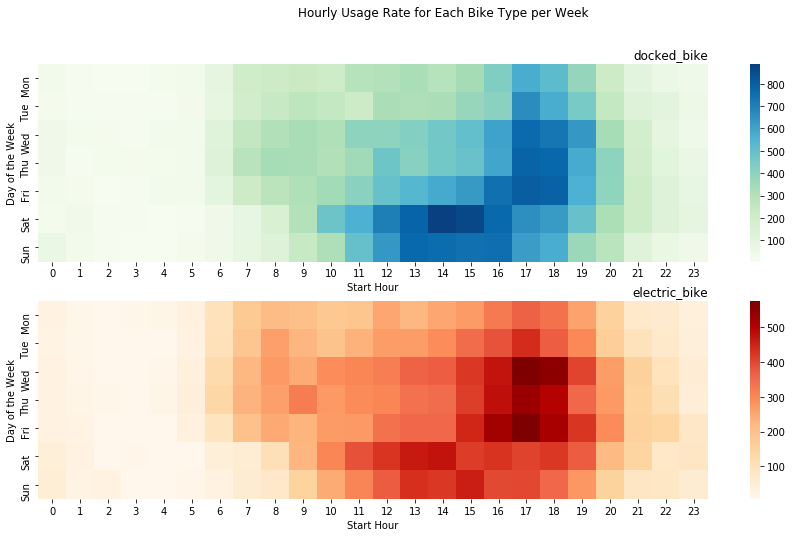

In [13]:
plt.figure(figsize = [15,8])
plt.suptitle('Hourly Usage Rate for Each Bike Type per Week')

plt.subplot(2,1,1)
docked = dfc.query('rideable_type == "docked_bike"')
dt_counts = docked.groupby(['started_day', 'started_hour']).size()
dt_counts = dt_counts.reset_index(name='count')
dt_counts = dt_counts.pivot(index='started_day', columns='started_hour', values='count')
sb.heatmap(dt_counts, cmap='GnBu');
plt.title('docked_bike', loc='right');
plt.xlabel('Start Hour');
plt.ylabel('Day of the Week');

plt.subplot(2,1,2)
electric = dfc.query('rideable_type == "electric_bike"')
et_counts = electric.groupby(['started_day', 'started_hour']).size()
et_counts = et_counts.reset_index(name='count')
et_counts = et_counts.pivot(index='started_day', columns='started_hour', values='count')
sb.heatmap(et_counts, cmap='OrRd');
plt.title('electric_bike', loc='right');
plt.xlabel('Start Hour');
plt.ylabel('Day of the Week');